# Pre analysis setup
## Note: The code creates a directory named "Investment_Graphs" for storing plot images.

In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, bs4
import os
import shutil

In [2]:
# plot constants for configuration
palette = {"venture":"g", "private_equity":"c", "seed": "m", "angel": "r"}
fontsize_title = 16
fontsize_axislabel = 14
figsize=[9,5]

# In case you want to generate images instead of plotting them in notebook
create_images = False

In [3]:
# Setting for some print statements which can aid copy paste to excel(set to True)
excelpaste_printing = False

In [4]:
imagefoldername = "Investment_Graphs"
imagefolderpath = "./{}".format(imagefoldername)
if os.path.exists(imagefolderpath): shutil.rmtree(imagefolderpath)
os.mkdir(imagefoldername)

# Plot helping funtions
def funding_roundtype_countplot(mstr_frame):
    """
    Plots the count of funding_roundtype for the given dataframe.
    """
    df = mstr_frame
    figure, ax = plt.subplots(figsize=figsize)
    funding_rndtype_counts = df.funding_round_type.astype('category').value_counts()
    funding_rndtypes = funding_rndtype_counts.index.array
    sns.barplot(funding_rndtypes, funding_rndtype_counts, order=funding_rndtypes, palette=palette)
    plt.title("Funding type frequencies", fontsize=fontsize_title)
    plt.xlabel('Funding type', fontsize=fontsize_axislabel)
    plt.ylabel('Frequency(log scale)', fontsize=fontsize_axislabel)
    ax.set_yscale('log')
    ax.set_xticklabels([" ".join(roundtype.split("_")).capitalize() for roundtype in funding_rndtypes])
    
    if create_images:
        plt.savefig(imagefolderpath+'/Fundtype_Frequencies.png', bbox_inches='tight')
    else:
        plt.show()
    

def funding_roundtype_totalfundingplot(mstr_frame):
    """
    Plots the total funding in the funding_roundtype for the given dataframe.
    """
    df = mstr_frame
    figure, ax = plt.subplots(figsize=figsize)
    splot = sns.barplot(df.funding_round_type, df.raised_amount_usd, estimator=np.sum, palette=palette, errwidth=0)
    plt.title("Total investments in funding types", fontsize=fontsize_title)
    plt.xlabel('Funding type', fontsize=fontsize_axislabel)
    plt.ylabel('Total Investment in USD', fontsize=fontsize_axislabel)
    funding_roundtypes = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticklabels([" ".join(str(roundtype).split("_")).capitalize() for roundtype in funding_roundtypes])
        
    for p in splot.patches:
        height = int(p.get_height())
        heightstr = "$ {:,}".format(height)
        
        splot.annotate(heightstr, 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    
    if create_images:
        plt.savefig(imagefolderpath+'/Fundtype_TotalFunding.png', bbox_inches='tight')
    else:
        plt.show()

def funding_roundtype_fundsdistplot(mstr_frame):
    """
    Plots the distribution of investments for the 
    """
    df = mstr_frame
    plt.figure(figsize=figsize)
    ax = sns.boxplot(df.funding_round_type, df.raised_amount_usd, palette=palette)
    plt.title("Investment distribution amongst funding types", fontsize=fontsize_title)
    plt.xlabel("Funding type", fontsize=fontsize_axislabel)
    plt.ylabel("Investment in USD", fontsize=fontsize_axislabel)
    
    ax.set_xticklabels([" ".join(str(roundtype).split("_")).capitalize() for roundtype in df.funding_round_type])
    
    if create_images:
        plt.savefig(imagefolderpath+'/Fundtype_FundingDistribution.png', bbox_inches='tight')
    else:
        plt.show()

-------------------------------------------------------------------
-------------------------------------------------------------------
# Checkpoint 1: Data Cleaning 1    

- Load the companies and rounds data (provided on the previous page) into two data frames and name them companies and rounds2 respectively.

In [5]:
# Load dataframes
encoding = 'palmos'
companies = pd.read_csv("companies.csv", encoding=encoding)
rounds2 = pd.read_csv("rounds2.csv", encoding=encoding)

## Observations on loading the df
- Supported encoding needs to be found as files dont load using the default encoding
    - One way is to use the command on terminal: file filename.csv but doesnt help much.
        - file companies.csv: Non-ISO extended-ASCII text, with very long lines, with CRLF line terminators
    - The other method is painful as we will need to go through a list of available encoding and try them out.
    - Tried changing the encoding almost 100 times and ran the Checkpoint 1 to come to the conclusion to use __palmos__ 

## Getting a feel of the initial dataset for companies

In [6]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB


In [7]:
companies.isnull().sum().sort_values(ascending=False)

founded_at       15221
state_code        8547
region            8030
city              8028
country_code      6958
homepage_url      5058
category_list     3148
name                 1
status               0
permalink            0
dtype: int64

In [8]:
companies.sample(3)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
5876,/Organization/Bark-Co,Bark & Co,http://bark.co,Pets,operating,USA,NY,New York City,New York,NaN
33346,/Organization/Loyalty-Builders,Loyalty Builders,http://www.loyaltybuilders.com/,Advertising,operating,USA,NH,Portsmouth,Portsmouth,01-01-1999
55803,/Organization/Sylob,SYLOB,http://www.sylob.com,Software,operating,FRA,B3,FRA - Other,Cambon,NaN


## Summary Getting a feel of the initial dataset for companies
- __Number of records__: 66,368
- __Number of columns__: 10
- __Columns having missing values__:
    - __founded_at__: 15,221
    - __state_code__: 08,547
    - __region__: 08,030
    - __city__: 08,028
    - __country_code__: 06,958
    - __homepage_url__: 05,058
    - __category_list__: 03,148
    - __name__: 00,001
- __Columns that can be dropped(In the assignment checkpoints these are not helpful for analysis)__:
    - homepage_url
    - state_code
    - region
    - city
    - founded_at
    
__Actions identified__:
1. Drop the columns that are not required
    

In [9]:
drop_columns = ["homepage_url", "state_code", "region", "city", "founded_at"]
companies = companies.iloc[:, ~(companies.columns.isin(drop_columns))]
companies.shape

(66368, 5)

## Getting a feel of the initial dataset for rounds2

In [10]:
rounds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [11]:
rounds2.describe()

,raised_amount_usd
count,9.495900e+04
mean,1.042687e+07
std,1.148212e+08
min,0.000000e+00
25%,3.225000e+05
50%,1.680511e+06
75%,7.000000e+06
max,2.127194e+10


In [12]:
rounds2.isnull().sum().sort_values(ascending=False)

funding_round_code         83809
raised_amount_usd          19990
funded_at                      0
funding_round_type             0
funding_round_permalink        0
company_permalink              0
dtype: int64

In [13]:
rounds2.sample(3)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
85685,/ORGANIZATION/SAMPLIFY-SYSTEMS,/funding-round/53e82b52e78636c662ee520082024f83,venture,NaN,01-01-2006,300000.0
76893,/ORGANIZATION/POLARIS-WIRELESS,/funding-round/80fa1a560983410569070df51d318b63,undisclosed,NaN,01-07-2001,NaN
91377,/ORGANIZATION/SNAPAPPOINTMENTS,/funding-round/a7e7ad8548a0c5cfa138fd62d9a07186,angel,NaN,10-11-2011,NaN


## Summary Getting a feel of the initial dataset for rounds2
- __Number of records__: 1,14,949
- __Number of columns__: 6
- __Columns having missing values__:
    - __funding_round_code__: 83,809
    - __raised_amount_usd__: 19,990
- __Columns that can be dropped(In the assignment checkpoints these are not helpful for analysis)__:
    - funding_round_code
    - funded_at
    - funding_round_permalink
    
__Actions identified__:
1. Drop the columns that are not required
    

In [14]:
drop_columns = ["funding_round_permalink", "funding_round_code", "funded_at"]
rounds2 = rounds2.iloc[:, ~(rounds2.columns.isin(drop_columns))]
rounds2.shape

(114949, 3)

#### Find answers to the questions given below:
1. How many unique companies are present in rounds2?

2. How many unique companies are present in companies?

3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.

4. Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N

5. Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?

In [15]:
# The company_permalink column might have permalinks representing the same company in lowercase as well as upper case.
# So lets lowercase the company_permalink column and find unique values
rounds2.company_permalink = rounds2.company_permalink.apply(lambda permalink: permalink.lower())
print("How many unique companies are present in rounds2?")
print("-", rounds2.company_permalink.nunique())
print("")




# The permalink column might have permalinks representing the same company in lowercase as well as upper case.
# So lets lowercase the permalink column and find unique values
companies.permalink = companies.permalink.apply(lambda permalink: permalink.lower())
print("How many unique companies are present in companies?")
print("-", companies.permalink.nunique())
print("")





#If the number of rows and number of unique values of any column match, then such columns are potential candidates 
#for being the unique keys.
companies_nrows = companies.shape[0]
companies_columns_nunique = companies.nunique()
uniquekey_candidates = list((companies_columns_nunique == companies_nrows)
                            .index[companies_columns_nunique == companies_nrows])

print("In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.")
print("-", uniquekey_candidates[0])
print("")




# Checking if all rounds2 company_permalink are in companies permalink
all_exist_in_companies = rounds2.company_permalink.isin(companies.permalink).sum() == rounds2.shape[0]
print("Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N")
print("- N" if all_exist_in_companies else "- Y")
print("")



master_frame = pd.merge(companies.rename(columns={"permalink":"company_permalink"}), rounds2, how="inner", on="company_permalink")
print("Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?")
print("-", master_frame.shape[0])

if excelpaste_printing:
    print("-------------Excel paste data Table - 1.1------------")
    print(rounds2.company_permalink.nunique())
    print(companies.permalink.nunique())
    print(uniquekey_candidates[0])
    print("N" if all_exist_in_companies else "Y")
    print(master_frame.shape[0])

How many unique companies are present in rounds2?
- 66368

How many unique companies are present in companies?
- 66368

In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.
- permalink

Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N
- N

Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?
- 114949


## Getting a feel of the initial dataset for master_frame

In [16]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 7 columns):
company_permalink     114949 non-null object
name                  114948 non-null object
category_list         111539 non-null object
status                114949 non-null object
country_code          106271 non-null object
funding_round_type    114949 non-null object
raised_amount_usd     94959 non-null float64
dtypes: float64(1), object(6)
memory usage: 7.0+ MB


In [17]:
master_frame.describe()

,raised_amount_usd
count,9.495900e+04
mean,1.042687e+07
std,1.148212e+08
min,0.000000e+00
25%,3.225000e+05
50%,1.680511e+06
75%,7.000000e+06
max,2.127194e+10


In [18]:
master_frame.isnull().sum().sort_values(ascending=False)

raised_amount_usd     19990
country_code           8678
category_list          3410
name                      1
funding_round_type        0
status                    0
company_permalink         0
dtype: int64

In [19]:
master_frame.sample(3)

,company_permalink,name,category_list,status,country_code,funding_round_type,raised_amount_usd
25260,/organization/curse,Curse,Digital Media|Technology|Video Games,operating,USA,venture,16000000.0
70365,/organization/ondore,Ondore,Big Data,operating,USA,seed,NaN
52455,/organization/keen-systems,Keen Systems,Cloud Infrastructure|CRM|E-Commerce|Enterprise...,operating,USA,seed,925000.0


In [20]:
master_frame.shape

(114949, 7)

## Summary Getting a feel of the initial dataset for master_frame
- __Number of records__: 1,14,949
- __Number of columns__: 8
- __Columns having missing values__:
    - __raised_amount_usd__: 19,990
    - __country_code__: 08,678
    - __category_list__: 03,410

## Summary Checkpoint 1: Data Cleaning 1
1. How many unique companies are present in rounds2? <br>
__66368__

2. How many unique companies are present in companies? <br>
__66368__

3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column. <br>
__permalink__

4. Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N <br>
__N__

5. Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame? <br>
__114949__

### Dropped columns
- companies
    - "homepage_url", "state_code", "region", "city", "founded_at"
- rounds2
    - "funding_round_permalink", "funding_round_code", "funded_at"

### mastet_frame shape: (114949, 7)


-------------------------------------------------------------------
-------------------------------------------------------------------
# Checkpoint 2: Funding Type Analysis
## This is the first of the three goals of data analysis – investment type analysis.
1. Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity) and report the answers in Table 2.1
2. Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?

In [21]:
print("status:\n", master_frame.status.unique())
print("\nfunding_round_type:\n", master_frame.funding_round_type.unique())

status:
 ['operating' 'acquired' 'closed' 'ipo']

funding_round_type:
 ['venture' 'seed' 'undisclosed' 'equity_crowdfunding' 'convertible_note'
 'private_equity' 'debt_financing' 'angel' 'grant' 'secondary_market'
 'post_ipo_equity' 'post_ipo_debt' 'product_crowdfunding'
 'non_equity_assistance']


In [22]:
# Remove closed companies as we are not considering closed companies
master_frame = master_frame[master_frame.status != "closed"]

# Filter the funding types "venture", "seed", "angel", "private_equity" as we are interested in those only.
interesting_funding_type = ["venture", "seed", "angel", "private_equity"]
master_frame = master_frame[master_frame.funding_round_type.isin(interesting_funding_type)]

#### Closed companies are not included in master_frame from this point onwards
#### Only venture, seed, angel, private equity funding type recorsd are included in master_frame from this point onwards

#### Applying constraints
1. 5 to 15 million USD
2. English-speaking countries

In [23]:
#------------------------------------------------------------------
# 1. 5 to 15 million USD
#------------------------------------------------------------------
master_frame = master_frame[(master_frame.raised_amount_usd >= 5000000) & (master_frame.raised_amount_usd <= 15000000)]
print("master_frame shape after USD constraint:", master_frame.shape)

# Capture for later use
#usd_constrained_mf = master_frame.copy()

#------------------------------------------------------------------
# 2. English-speaking countries
#------------------------------------------------------------------
# We need to scrape english speaking countries from wiki url
# We use beautiful soup for this
url = "https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language"
response = requests.get(url)
soup = bs4.BeautifulSoup(response.text.replace("wikitable sortable", "wikitable_sortable"), "html5lib")

# Extract country codes from first 2 tables
country_codes =[str(row.select('td')[1]).lstrip("<td>").rstrip("\n</td>") for table in soup.find_all(name="table", attrs={"class":"wikitable_sortable"})[0:2] for row in table.select('tr')[1:]]

# The numbers might not add up as the numbering in wiki is flawed
print("Country codes in first 2 tables of wiki:", len(country_codes))

# The 3 table has no country codes. So we fetch from by visiting every wiki dedicated to each country.
# Probably these codes wont be useful because in countries table all country codes are of length
more_country_codes = ["BH", "BD", "BN", "KH", "CY", "ER", "ET", "IL", "JO", "KW", "MY", "MV", "MM", "OM", "QA", "LK", "AE"]
len(more_country_codes)
final_country_codes = country_codes + more_country_codes
print("-----------------------------------------")
print(final_country_codes)
print("-----------------------------------------")
print("Total country codes:", len(final_country_codes))
# We ignore the the other tables as they are not countries

# Filter the records in master_df with English speaking countries
print("-----------------------------------------")
master_frame = master_frame[master_frame.country_code.isin(final_country_codes)]
print("master_frame shape after country constraints:", master_frame.shape)


master_frame shape after USD constraint: (16099, 7)
Country codes in first 2 tables of wiki: 58
-----------------------------------------
['AUS', 'NZL', 'GBR', 'USA', 'ATG', 'BHS', 'BRB', 'BLZ', 'BWA', 'BDI', 'CMR', 'CAN', 'DMA', 'SWZ', 'FJI', 'GMB', 'GHA', 'GRD', 'GUY', 'IND', 'IRL', 'JAM', 'KEN', 'KIR', 'LSO', 'LBR', 'MWI', 'MLT', 'MHL', 'MUS', 'FSM', 'NAM', 'NRU', 'NGA', 'PAK', 'PLW', 'PNG', 'PHL', 'RWA', 'KNA', 'LCA', 'VCT', 'WSM', 'SYC', 'SLE', 'SGP', 'SLB', 'ZAF', 'SSD', 'SDN', 'TZA', 'TON', 'TTO', 'TUV', 'UGA', 'VUT', 'ZMB', 'ZWE', 'BH', 'BD', 'BN', 'KH', 'CY', 'ER', 'ET', 'IL', 'JO', 'KW', 'MY', 'MV', 'MM', 'OM', 'QA', 'LK', 'AE']
-----------------------------------------
Total country codes: 75
-----------------------------------------
master_frame shape after country constraints: (13408, 7)


#### Constraints have been applied by this point:
1. Only venture, private equity, angel and seed funding types 
2. 5 to 15 million USD
3. English-speaking countries

In [24]:
# TOUSE: Checkpoint 6
cp6_master_frame = master_frame.copy()

In [25]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13408 entries, 0 to 114936
Data columns (total 7 columns):
company_permalink     13408 non-null object
name                  13408 non-null object
category_list         13337 non-null object
status                13408 non-null object
country_code          13408 non-null object
funding_round_type    13408 non-null object
raised_amount_usd     13408 non-null float64
dtypes: float64(1), object(6)
memory usage: 838.0+ KB


In [26]:
master_frame.isnull().sum()

company_permalink      0
name                   0
category_list         71
status                 0
country_code           0
funding_round_type     0
raised_amount_usd      0
dtype: int64

In [27]:
# category_list values cannot be imputed.
# So we drop the rows where category_list is missing.
master_frame = master_frame[~master_frame.category_list.isnull()]
master_frame.isnull().sum()

company_permalink     0
name                  0
category_list         0
status                0
country_code          0
funding_round_type    0
raised_amount_usd     0
dtype: int64

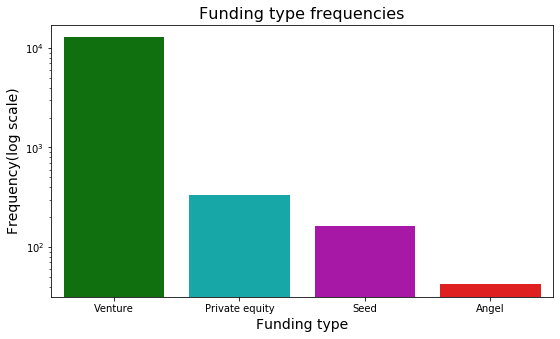

In [28]:
funding_roundtype_countplot(master_frame)

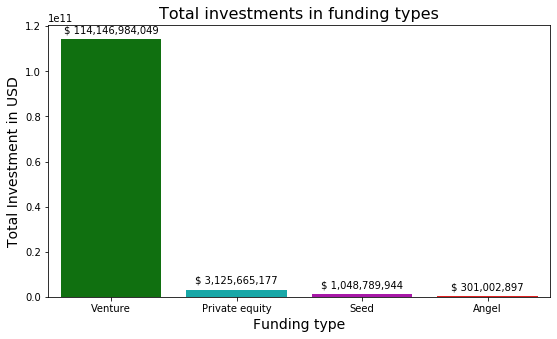

In [29]:
funding_roundtype_totalfundingplot(master_frame)

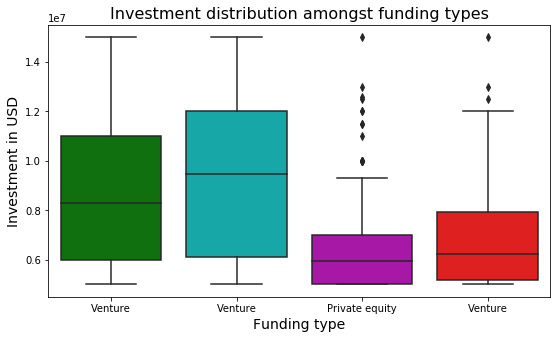

In [30]:
funding_roundtype_fundsdistplot(master_frame)

#### Observations after applying constraints
- Number of rounds ranks
    1. venture
    2. private_equity
    3. seed
    4. angel
- Total Funding ranks
    1. venture 
    2. private_equity 
    3. seed
    4. angel 
- Spread of fundings
    - The __investments__ in the four funding types is __not evenly spread between 5-15 million USD__

#### 1. Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity) and report the answers in Table 2.1

In [31]:
funding_type_group = master_frame.groupby('funding_round_type')
funding_analysis = funding_type_group["raised_amount_usd"].describe()
funding_analysis["mean_median_diff"] = (funding_analysis["mean"] - funding_analysis["50%"]).apply(lambda x: abs(x))
funding_analysis["mean_median_diff"] = funding_analysis["mean_median_diff"].apply(lambda x: "{:e}".format(round(x, 1)))
funding_analysis["75_25_diff"] = funding_analysis["75%"] - funding_analysis["25%"]
funding_analysis["mode"] = funding_type_group["raised_amount_usd"].agg(lambda x: x.mode())
funding_analysis["mode"] = funding_analysis["mode"].apply(lambda x: "{:e}".format(x))
funding_analysis

,count,mean,std,min,25%,50%,75%,max,mean_median_diff,75_25_diff,mode
funding_round_type,,,,,,,,,,,
angel,42.0,7.166736e+06,2.503679e+06,5000000.0,5187500.0,6250000.0,7925000.0,15000000.0,9.167356e+05,2737500.0,5.000000e+06
private_equity,336.0,9.302575e+06,3.157642e+06,5000000.0,6111540.0,9488683.0,12000000.0,15000000.0,1.861081e+05,5888460.0,1.000000e+07
seed,162.0,6.474012e+06,1.940331e+06,5000000.0,5000000.0,5965737.5,6989550.0,15000000.0,5.082745e+05,1989550.0,5.000000e+06
venture,12797.0,8.919824e+06,3.069142e+06,5000000.0,6002724.0,8300000.0,11000000.0,15000000.0,6.198237e+05,4997276.0,1.000000e+07


### Angel:
- __Lowest Frequency(Less investors)__: 42
- __Lowest Total Funding(Less investors)__
- Majority of values below 79,25,000 which is the 75 percentile which is much less than the max value of 1,50,00,000
- So __median__ is a good choice
- __Representative value:__ 62,50,000


### Private Equity:
- __Second Highest Frequency(Decent amount of investors)__: 337
- __Second Highest Funding(Decent amount of investors)__
- Majority of values below 1,20,00,000 which is the 75 percentile which is less than the max value of 1,50,00,000
- So __median__ is a good choice
- __Representative value:__ 94,88,683 ~ 94,00,000

### Seed: 
- __Third Highest Frequency(Fairly low investors)__ 
- __Third Highest Funding(Fairly low investors)__
- Majority of values below 69,89,550 which is the 75 percentile which is much less than the max value of 1,50,00,000
- So __median__ is a good choice
- __Representative value:__ 5965737 ~ 59,00,000

### Venture:
- __Highest Frequency(Max investors)__: 12866
- __Highest Funding(Max investors)__
- Majority of values below 1,10,00,000 which is the 75 percentile which is less than the max value of 1,50,00,000
- So __median__ is a good choice
- __Representative value:__ 83,00,000




#### 2. Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?

- By count __venture__ followed by __private equity__ have the max rounds of funding.
- Also the representative values for __venture__ and __private equity__ is __83,00,000__ and __94,00,000__ respectively which are __between the companies constraint of the amount range 5-15 million__.
- So considering the points above we choose __Venture__ as the type to invest in for Spark Funds.
- Investment type suitable for Spark Funds: __Venture__

In [32]:
# As we have selected venture funding lets filter for the same
venture_master_frame = master_frame[master_frame.funding_round_type == "venture"]
venture_master_frame.sample(3)

,company_permalink,name,category_list,status,country_code,funding_round_type,raised_amount_usd
38277,/organization/fuzzy-logix,Fuzzy Logix,Software,operating,USA,venture,5500000.0
1410,/organization/accelecare,AcceleCare Wound Centers,Health Care|Hospitals|Medical,acquired,USA,venture,10000000.0
106515,/organization/verisilicon-holdings,VeriSilicon Holdings,Cloud Computing|Manufacturing,operating,USA,venture,7999998.0


In [33]:
# We can drop the funding_round_type now as it only consists of venture funding
venture_master_frame = venture_master_frame.iloc[:, ~(venture_master_frame.columns == "funding_round_type")]
venture_master_frame.sample(3)

,company_permalink,name,category_list,status,country_code,raised_amount_usd
8581,/organization/attachstor,AttachSTOR,Information Technology|Services,operating,USA,7500000.0
52394,/organization/kdw,KDW,Business Services|Consulting|Finance,operating,USA,6800000.0
108254,/organization/vizu,Vizu Corporation,Advertising,acquired,USA,6750000.0


In [34]:
master_frame.shape

(13337, 7)

In [35]:
venture_master_frame.shape

(12797, 6)

## Summary Checkpoint 2: Funding Type Analysis
1. Removed closed companies.
2. Filtered data frame to include on the funding types: "venture", "seed", "angel", "private_equity".
3. Applied constraints and did the analysis.
5. Identified __Venture__ as the funding type to invest in.

__Representative Values of investments__:
- angel:          62,50,000
- private equity: 94,00,000
- seed:           59,00,000
- venture:        83,00,000

### master_frame shape: (13337, 7)
### venture_master_frame: (12797, 6)

-------------------------------------------------------------------
-------------------------------------------------------------------
# Checkpoint 3: Country Analysis
1. Spark Funds wants to see the top nine countries which have received the highest total funding (across ALL sectors for the chosen investment type)
2. For the chosen investment type, make a data frame named top9 with the top nine countries (based on the total investment amount each country has received) 

__Identify the top three English-speaking countries in the data frame top9.__


#### 1. Spark Funds wants to see the top nine countries which have received the highest total funding (across ALL sectors for the chosen investment type)

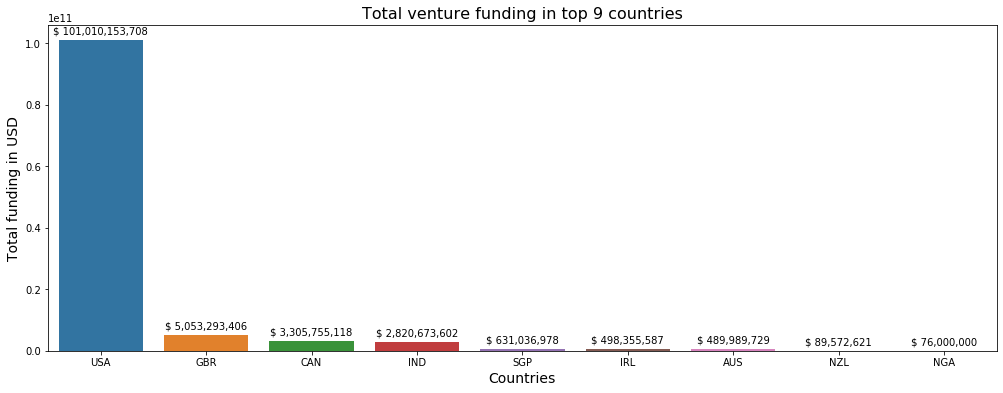

In [36]:
countries_totalfunding = venture_master_frame.groupby("country_code")["raised_amount_usd"].sum()
top9_countries_totalfunding = countries_totalfunding.sort_values(ascending=False)[:9]

fig, ax = plt.subplots(figsize=[17,6])
splot = sns.barplot(top9_countries_totalfunding.index, top9_countries_totalfunding.values, orient="V")
plt.title("Total venture funding in top 9 countries", fontsize=fontsize_title)
plt.ylabel("Total funding in USD", fontsize=fontsize_axislabel)
plt.xlabel("Countries", fontsize=fontsize_axislabel)

for p in splot.patches:
    height = int(p.get_height())
    heightstr = "$ {:,}".format(height)

    splot.annotate(heightstr, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

if create_images:
    plt.savefig(imagefolderpath+'/Top9_totalventurefunding.png', bbox_inches='tight')
else:
    plt.show()

#### 2. For the chosen investment type, make a data frame named top9 with the top nine countries (based on the total investment amount each country has received) 

In [37]:
top9 = pd.DataFrame(index=top9_countries_totalfunding.index)
top9["total_funding_usd"] = top9_countries_totalfunding.values
top9

,total_funding_usd
country_code,
USA,1.010102e+11
GBR,5.053293e+09
CAN,3.305755e+09
IND,2.820674e+09
SGP,6.310370e+08
IRL,4.983556e+08
AUS,4.899897e+08
NZL,8.957262e+07
NGA,7.600000e+07


#### Table 3.1:
#### Identify the top three English-speaking countries in the data frame top9.

In [38]:
top9.iloc[:3]

,total_funding_usd
country_code,
USA,1.010102e+11
GBR,5.053293e+09
CAN,3.305755e+09


In [39]:
master_frame.shape

(13337, 7)

In [40]:
venture_master_frame.shape

(12797, 6)

## Summary Checkpoint 3: Country Analysis
1. Plotted graph of countries with top 9 total funding.
2. Created __top9__ dataframe of countries with top 9 total investments.
3. Identified top three English-speaking countries in the data frame top9: __USA__, __GRB__, __CAN__

### master_frame shape: (13337, 7)
### venture_master_frame: (12797, 6)

-------------------------------------------------------------------
-------------------------------------------------------------------
# Checkpoint 4: Sector Analysis 1


In [41]:
def extractprimarysectorin(df):
    """
    Function to extract primary_sector from category_list column in the dataframe passed
    as the parameter
    """
    # Find the number of missing values
    category_list_isnull = df.category_list.isnull()
    category_list_nullcount = category_list_isnull.sum()

    if category_list_nullcount > 0:
        # Remove rows with category_list null
        df = df[~category_list_isnull]
    
    # Applying the business rule discussed with CEO to create primary_sector
    df["primary_sector"] = df.category_list.apply(lambda x: x.split("|")[0])

#### 1. Extract the primary sector of each category list from the category_list column

In [42]:
extractprimarysectorin(venture_master_frame)
venture_master_frame.sample(3)

,company_permalink,name,category_list,status,country_code,raised_amount_usd,primary_sector
70934,/organization/open-mile,Open Mile,Automotive|Enterprise Software|Shipping|Softwa...,acquired,USA,6000000.0,Automotive
112416,/organization/xstream-systems,XStream Systems,Hardware + Software,operating,USA,6305369.0,Hardware + Software
50135,/organization/irvine-sensors-corporation,Irvine Sensors Corporation,Nanotechnology,operating,USA,5140000.0,Nanotechnology


In [43]:
# Remove category_list column as its not required anymore
venture_master_frame = venture_master_frame.iloc[:, ~(venture_master_frame.columns == "category_list")]
venture_master_frame.sample(3)

,company_permalink,name,status,country_code,raised_amount_usd,primary_sector
22456,/organization/compete,Compete,acquired,USA,6000000.0,Advertising
45346,/organization/hydration-labs,Hydration Labs,operating,USA,6246962.0,Clean Technology
71558,/organization/orbotix,Sphero,operating,USA,5000000.0,Android


#### Loading mapping dataframe

In [44]:
mapping = pd.read_csv("mapping.csv")
mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 10 columns):
category_list                              687 non-null object
Automotive & Sports                        688 non-null int64
Blanks                                     688 non-null int64
Cleantech / Semiconductors                 688 non-null int64
Entertainment                              688 non-null int64
Health                                     688 non-null int64
Manufacturing                              688 non-null int64
News, Search and Messaging                 688 non-null int64
Others                                     688 non-null int64
Social, Finance, Analytics, Advertising    688 non-null int64
dtypes: int64(9), object(1)
memory usage: 53.9+ KB


In [45]:
mapping.sample()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
512,Peer-to-Peer,0,0,0,0,0,0,1,0,0


#### 2. Use the mapping file 'mapping.csv' to map each primary sector to one of the eight main sectors (Note that ‘Others’ is also considered one of the main sectors)

In [46]:
# For mapping dataframe check if multiple sectors in a row have 1 or not
sum_all_1s = mapping.iloc[:, 1:].sum(axis=1).sum()
sum_all_1s_equals_row_count = (sum_all_1s == mapping.shape[0])
if sum_all_1s_equals_row_count:
    print("Each row has only one sector set to 1 rest are set to 0")
else:
    print("Rows might have more then once sector set to 1")

Each row has only one sector set to 1 rest are set to 0


#### As a result of the above test it can be assumed that only one of the sectors in a row has 1 and rest have 0. So a company has only one main sector.

In [47]:
# We can drop row at index 0 and column 'Blanks' as they are fillers
# We have also dropped rows with category_list as NAN
mapping = mapping.iloc[1:, ~(mapping.columns == "Blanks")]
mapping.head()

,category_list,Automotive & Sports,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
1,3D,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,1,0,0,0,0


In [48]:
mapping.reset_index(drop=True, inplace=True)

In [49]:
# Check category_list has unique values only
has_unique_values = mapping.category_list.apply(lambda cat: cat.lower()).nunique() == mapping.shape[0]
if has_unique_values:
    print("mapping category_list column has unique values")
else:
    print("mapping category_list column has some duplicates")

mapping category_list column has unique values


__Creating a derived main_sector depending on the existing variables__

In [50]:
# melt function creates two new columns variable and value. It drop the columns not passed to the function.
# It then adds the column name and value in the variable and value function for each row.
melt_mapping = pd.melt(mapping, "category_list")

# We then filter rows with value as 1 to identify the sectors for the category_list
melt_mapping = melt_mapping[melt_mapping.value == 1]
print(melt_mapping.shape)
melt_mapping.sample(4)

(687, 3)


,category_list,variable,value
3172,Manufacturing,Manufacturing,1
3226,New Technologies,Manufacturing,1
4609,Oil and Gas,Others,1
4507,iPad,Others,1


In [51]:
# Remove the value column as it contains only 1 as the value and rename column "variable" to "main_sector"
# Store the result back in mapping
mapping = melt_mapping.rename(columns={"variable": "main_sector"}).iloc[:, :-1]
mapping.sample(3)

,category_list,main_sector
5228,Lotteries,"Social, Finance, Analytics, Advertising"
1596,Educatio0l Games,Entertainment
4365,Enterprise Application,Others


In [52]:
mapping.shape

(687, 2)

In [53]:
# Merging will involve comparison of mapping category_list and primary_sector_frame primary_sector.
# So lets lowercase both
mapping.category_list = mapping.category_list.apply(lambda x: x.lower())
venture_master_frame.primary_sector = venture_master_frame.primary_sector.apply(lambda x: x.lower())

In [54]:
inp_sector_analysis2 = pd.merge(venture_master_frame, mapping.loc[:, ["category_list","main_sector"]].rename(columns={"category_list": "primary_sector"}), how="inner", on="primary_sector")

In [55]:
print(inp_sector_analysis2.shape)

(11807, 7)


In [56]:
inp_sector_analysis2.sample(3)

,company_permalink,name,status,country_code,raised_amount_usd,primary_sector,main_sector
4210,/organization/pubmatic,PubMatic,operating,USA,7000000.0,advertising,"Social, Finance, Analytics, Advertising"
8920,/organization/appfolio,Appfolio,ipo,USA,8000000.0,real estate,Others
8471,/organization/hashicorp,HashiCorp,operating,USA,10000000.0,development platforms,"Social, Finance, Analytics, Advertising"


In [57]:
master_frame.shape

(13337, 7)

In [58]:
venture_master_frame.shape

(12797, 6)

In [59]:
inp_sector_analysis2.shape

(11807, 7)

## Summary Checkpoint 4: Sector Analysis 1
1. Extracted the __primary sector__ of each category list from the __category_list column__ in __venture_master_frame__ using business logic.
2. Used the mapping file 'mapping.csv' to map each primary sector to one of the eight main sectors
    1. Created mapping df.
    2. Dropped row at index 0 and column 'Blanks' as they are fillers from the mapping df
    3. Reset index of mapping.
    4. Created derived variable __main_sector__ in mapping.
    5. Formed __inner merge__ of __venture_master_frame__ and __mapping__ for __primary_sector__ into inp_sector_analysis2.
    
### master_frame shape: (13337, 7)
### venture_master_frame: (12797, 6)
### inp_sector_analysis2: (11807, 7)
    

-------------------------------------------------------------------
-------------------------------------------------------------------
# Checkpoint 5: Sector Analysis 2

#### 1. Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range. The three data frames should contain:
- All the columns of the master_frame along with the primary sector and the main sector
- The total number (or count) of investments for each main sector in a separate column
- The total amount invested in each main sector in a separate column

##### We can use inp_sector_analysis2 from Checkpoint 4 to get D1, D2, D3 as it is filtered for FT and investment range 5-15 million USD and also contains main_sector.

__All the columns of the master_frame along with the primary sector and the main sector__

In [60]:
def makedfforcountrycode(df, countrycode):
    return df[df.country_code == countrycode]

In [61]:
D1 = makedfforcountrycode(inp_sector_analysis2, "USA")
D2 = makedfforcountrycode(inp_sector_analysis2, "GBR")
D3 = makedfforcountrycode(inp_sector_analysis2, "CAN")

drop_columns = ["country_code", "category_list"]
D1 = D1.iloc[:, ~(D1.columns.isin(drop_columns))]
D2 = D2.iloc[:, ~(D2.columns.isin(drop_columns))]
D3 = D3.iloc[:, ~(D3.columns.isin(drop_columns))]

__The total number (or count) of investments for each main sector in a separate column__

In [62]:
def setmainsectorfrequencycolumn(df):
    main_sector_frequencies = df.main_sector.astype('category').value_counts()
    df["count_main_sector"] = df.main_sector.apply(lambda sector: main_sector_frequencies[sector])

In [63]:
setmainsectorfrequencycolumn(D1)
setmainsectorfrequencycolumn(D2)
setmainsectorfrequencycolumn(D3)

__The total amount invested in each main sector in a separate column__

In [64]:
def setmainsectortotalfundingcolumn(df):
    main_sector_totalfunding = df.groupby("main_sector")["raised_amount_usd"].sum()
    df["total_funding_main_sector"] = df.main_sector.apply(lambda sector: main_sector_totalfunding[sector])

In [65]:
setmainsectortotalfundingcolumn(D1)
setmainsectortotalfundingcolumn(D2)
setmainsectortotalfundingcolumn(D3)

In [66]:
D1.sample(3)

,company_permalink,name,status,raised_amount_usd,primary_sector,main_sector,count_main_sector,total_funding_main_sector
9883,/organization/walls-holding,Walls Holding,operating,5225260.0,consumer goods,Manufacturing,739,6.700079e+09
9918,/organization/outside-in,Outside.in,acquired,7000000.0,communities,"Social, Finance, Analytics, Advertising",1813,1.590572e+10
8373,/organization/dealertrack,Dealertrack,acquired,10000000.0,business services,"Social, Finance, Analytics, Advertising",1813,1.590572e+10


In [67]:
D2.sample(3)

,company_permalink,name,status,raised_amount_usd,primary_sector,main_sector,count_main_sector,total_funding_main_sector
2354,/organization/cell-medica,Cell Medica,operating,7290000.0,biotechnology,Cleantech / Semiconductors,114,1.028029e+09
1140,/organization/semmle,Semmle,operating,8000000.0,software,Others,137,1.189442e+09
11416,/organization/ecourier,eCourier.co.uk,acquired,6064606.0,algorithms,Others,137,1.189442e+09


In [68]:
D3.sample(3)

,company_permalink,name,status,raised_amount_usd,primary_sector,main_sector,count_main_sector,total_funding_main_sector
6974,/organization/get-myo,Thalmic Labs,operating,14500000.0,health and wellness,Health,17,143960390.0
6617,/organization/vantrix,Vantrix,operating,10000000.0,mobile,"News, Search and Messaging",44,406121113.0
5475,/organization/fresche-legacy,Fresche Legacy,operating,7800000.0,consulting,"Social, Finance, Analytics, Advertising",50,422343073.0


#### 2. Table 5.1: Based on the analysis of the sectors, which main sectors and countries would you recommend Spark Funds to invest in? Present your conclusions in the presentation. The conclusions are subjective (i.e. there may be no ‘one right answer’), but it should be based on the basic strategy — invest in sectors where most investments are occurring. 

In [69]:
def maxfundedcompany(withinsector, lookindf):
    sector = withinsector
    df = lookindf
    sector_df = df[df.main_sector == sector]
    company_permalink_group = sector_df.groupby("company_permalink")
    raised_amount_sums = company_permalink_group["raised_amount_usd"].sum()
    max_raised_amount_permalink = raised_amount_sums.sort_values(ascending=False).index[0]
    sector_maxfunded_company = sector_df[sector_df.company_permalink == max_raised_amount_permalink].name.iloc[0]
    return sector_maxfunded_company


def table_5_1_sectorwiseinvestmentanalysis(df, annote):
    main_sector_value_counts = df.main_sector.astype('category').value_counts()

    top_sector_name = main_sector_value_counts.index[0]
    second_sector_name = main_sector_value_counts.index[1]
    third_sector_name = main_sector_value_counts.index[2]
    
    ninvestments_topsector = main_sector_value_counts[0]
    ninvestments_secondsector = main_sector_value_counts[1]
    ninvestments_thirdsector = main_sector_value_counts[2]
    
    top_sector_maxfunded_company = maxfundedcompany(withinsector=top_sector_name, lookindf=df)
    second_sector_maxfunded_company = maxfundedcompany(withinsector=second_sector_name, lookindf=df)

    if annote:
        print("1. Total number of investments (count):", df.shape[0])
        print("2. Total amount of investment (USD):", df.raised_amount_usd.sum())
        print("3. Top sector (based on count of investments):", top_sector_name)
        print("4. Second-best sector (based on count of investments):", second_sector_name)
        print("5. Third-best sector (based on count of investments):", third_sector_name)
        print("6. Number of investments in the top sector (refer to point 3):", ninvestments_topsector)
        print("7. Number of investments in the second-best sector (refer to point 4):", ninvestments_secondsector)
        print("8. Number of investments in the third-best sector (refer to point 5):", ninvestments_thirdsector)
        print("9. For the top sector count-wise (point 3), which company received the highest investment?:", top_sector_maxfunded_company)
        print("10. For the second-best sector count-wise (point 4), which company received the highest investment?:", second_sector_maxfunded_company)
    else:
        print(df.shape[0])
        print(df.raised_amount_usd.sum())
        print(top_sector_name)
        print(second_sector_name)
        print(third_sector_name)
        print(ninvestments_topsector)
        print(ninvestments_secondsector)
        print(ninvestments_thirdsector)
        print(top_sector_maxfunded_company)
        print(second_sector_maxfunded_company)

In [70]:
print("USA")
table_5_1_sectorwiseinvestmentanalysis(D1, annote=True)
print("----------------------------------------")
print("GBR")
table_5_1_sectorwiseinvestmentanalysis(D2, annote=True)
print("----------------------------------------")
print("CAN")
table_5_1_sectorwiseinvestmentanalysis(D3, annote=True)


if excelpaste_printing:
    print("-----------------Excel paste data Table-5.1----------------------")
    print("USA")
    table_5_1_sectorwiseinvestmentanalysis(D1, annote=False)
    print("----------------------------------------")
    print("GBR")
    table_5_1_sectorwiseinvestmentanalysis(D2, annote=False)
    print("----------------------------------------")
    print("CAN")
    table_5_1_sectorwiseinvestmentanalysis(D3, annote=False)

USA
1. Total number of investments (count): 10404
2. Total amount of investment (USD): 93176222534.0
3. Top sector (based on count of investments): Others
4. Second-best sector (based on count of investments): Cleantech / Semiconductors
5. Third-best sector (based on count of investments): Social, Finance, Analytics, Advertising
6. Number of investments in the top sector (refer to point 3): 157
7. Number of investments in the second-best sector (refer to point 4): 2145
8. Number of investments in the third-best sector (refer to point 5): 520
9. For the top sector count-wise (point 3), which company received the highest investment?: Virtustream
10. For the second-best sector count-wise (point 4), which company received the highest investment?: Biodesix
----------------------------------------
GBR
1. Total number of investments (count): 542
2. Total amount of investment (USD): 4728734985.0
3. Top sector (based on count of investments): Others
4. Second-best sector (based on count of inve

In [71]:
master_frame.shape

(13337, 7)

In [72]:
venture_master_frame.shape

(12797, 6)

In [73]:
inp_sector_analysis2.shape

(11807, 7)

## Summary Checkpoint 5: Sector Analysis 2
1. Made D1, D2, D3 filtered for top 3 countries namely __USA__, __GBR__, __CAN__, filtererd for __venture__ funding and __raised_amount_usd__ in __5-15 million USD__.
2. Created column __count_main_sector__ to D1, D2, D3 which contains the number of investments in different main sectors. This is redundant data as it repeats in multiple rows in my opinion.
3. Created column __total_funding_main_sector__ to D1, D2, D3 which contains the total investment in different main sectors. This is redundant data as it repeats in multiple rows in my opinion.
4. Created __report__ for Table 5.1 in the excel sheets.

### master_frame shape: (13337, 7)
### venture_master_frame: (12797, 6)
### inp_sector_analysis2: (11807, 7)


-------------------------------------------------------------------
-------------------------------------------------------------------
# Checkpoint 6: Plots

1. A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

__For 1 we can use cp6_master_frame which is filtered for venture, private equity, angel, seed and 5-15 million USD and for english speaking countries. It is created in Checkpoint 2.__

__For 2 we can use top9 which contains top 9 countries for total investments. It is created in Checkpoint 3.__

__For 3 we can use inp_sector_analysis2 from Checkpoint 4 and top9 from Checkpoint 3. inp_sector_analysis2 is filtered for FT and investment range 5-15 million USD and also contains main_sector.__

In [74]:
# Search # TOUSE: Checkpoint 6 to go to point of ceation of cp6_master_frame
cp6_master_frame.sample(3)

,company_permalink,name,category_list,status,country_code,funding_round_type,raised_amount_usd
66188,/organization/naviscan,Naviscan,Biotechnology,operating,USA,venture,15000000.0
35293,/organization/fiberzone-networks,FiberZone Networks,Analytics,operating,USA,venture,8000000.0
49056,/organization/intercloud-systems,Intercloud Systems,Analytics,ipo,USA,venture,11625000.0


In [75]:
# Look for nulls
cp6_master_frame.raised_amount_usd.isnull().sum()

0

In [76]:
# Look for nulls
cp6_master_frame.funding_round_type.isnull().sum()

0

#### 1. A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

In [77]:
cp6_master_frame.country_code.nunique()

16

In [78]:
# Removing records without country code
cp6_master_frame = cp6_master_frame[~cp6_master_frame.country_code.isnull()]

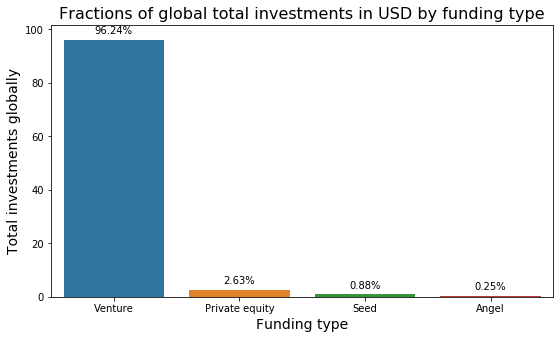

In [79]:
figure, ax = plt.subplots(figsize = figsize)

total_global_funding = cp6_master_frame.raised_amount_usd.sum()
fraction_estimator = lambda fundingtype_investments: 100 * (fundingtype_investments.sum() / total_global_funding)

splot = sns.barplot(cp6_master_frame.funding_round_type, cp6_master_frame.raised_amount_usd, estimator=fraction_estimator, errwidth=0)
plt.title("Fractions of global total investments in USD by funding type", fontsize=fontsize_title)
plt.xlabel("Funding type", fontsize=fontsize_axislabel)
plt.ylabel("Total investments globally", fontsize=fontsize_axislabel)

funding_roundtypes = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels([" ".join(str(roundtype).split("_")).capitalize() for roundtype in funding_roundtypes])
        
for p in splot.patches:
    heightstr = "{:.2f}%".format(p.get_height())

    splot.annotate(heightstr, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

if create_images:
    plt.savefig(imagefolderpath+'/Fractions_globalinvestments.png', bbox_inches='tight')
else:
    plt.show()

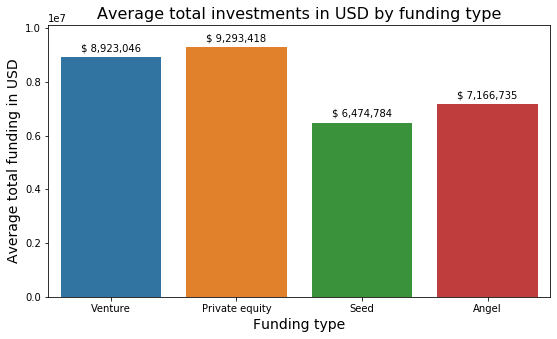

In [80]:
figure, ax = plt.subplots(figsize = figsize)
splot = sns.barplot(cp6_master_frame.funding_round_type, cp6_master_frame.raised_amount_usd, errwidth=0)
plt.title("Average total investments in USD by funding type", fontsize=fontsize_title)
plt.xlabel("Funding type", fontsize=fontsize_axislabel)
plt.ylabel("Average total funding in USD", fontsize=fontsize_axislabel)

funding_roundtypes = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels([" ".join(str(roundtype).split("_")).capitalize() for roundtype in funding_roundtypes])

for p in splot.patches:
    height = int(p.get_height())
    heightstr = "$ {:,}".format(height)

    splot.annotate(heightstr, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

if create_images:
    plt.savefig(imagefolderpath+'/Average_total_investments.png', bbox_inches='tight')
else:
    plt.show()

#### 2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

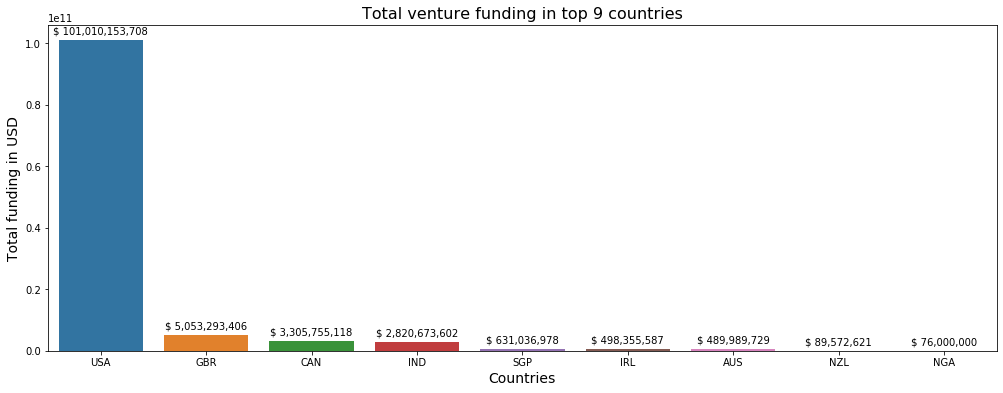

In [81]:
fig, ax = plt.subplots(figsize=[17,6])
splot = sns.barplot(top9.index, top9.total_funding_usd.values, orient="V")
plt.title("Total venture funding in top 9 countries", fontsize=fontsize_title)
plt.ylabel("Total funding in USD", fontsize=fontsize_axislabel)
plt.xlabel("Countries", fontsize=fontsize_axislabel)

for p in splot.patches:
    height = int(p.get_height())
    heightstr = "$ {:,}".format(height)

    splot.annotate(heightstr, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

if create_images:
    plt.savefig(imagefolderpath+'/Top9_totalventurefunding.png', bbox_inches='tight')
else:
    plt.show()

#### 3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

In [82]:
inp_sector_analysis2.country_code.unique()

array(['IND', 'GBR', 'USA', 'CAN', 'AUS', 'SGP', 'IRL', 'NZL', 'NGA',
       'PHL', 'KEN', 'ZAF', 'PAK', 'MLT', 'KNA', 'GHA'], dtype=object)

In [83]:
#Filter the 3 countries from inp_sector_analysis2
top3 = inp_sector_analysis2[inp_sector_analysis2.country_code.isin(top9.index[:3])]
top3.country_code.unique()

array(['GBR', 'USA', 'CAN'], dtype=object)

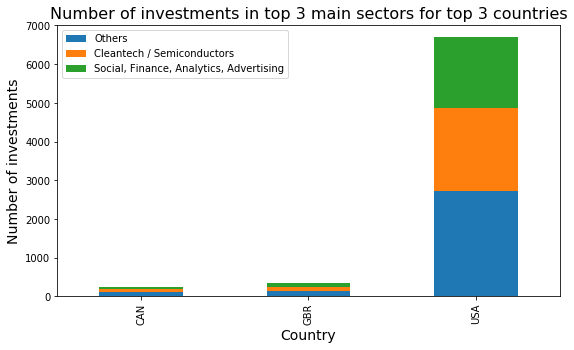

In [84]:
country_group = top3.groupby("country_code")
mainsector_value_counts = country_group["main_sector"].apply(lambda x: x.value_counts()[0:3])

mainsector_value_counts.unstack().plot.bar(stacked=True, figsize=figsize)
plt.title("Number of investments in top 3 main sectors for top 3 countries", fontsize=fontsize_title)
plt.xlabel("Country", fontsize=fontsize_axislabel)
plt.ylabel("Number of investments", fontsize=fontsize_axislabel)

if create_images:
    plt.savefig(imagefolderpath+'/Top3sectors_top3countries.png', bbox_inches='tight')
else:
    plt.show()

In [85]:
master_frame.shape

(13337, 7)

In [86]:
venture_master_frame.shape

(12797, 6)

In [87]:
inp_sector_analysis2.shape

(11807, 7)

## Summary Checkpoint 6: Plots
1. A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds. __Plotted__

2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear. __Plotted__

3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). __Plotted__

### master_frame shape: (13337, 7)
### venture_master_frame: (12797, 6)
### inp_sector_analysis2: (11807, 7)